In [1]:
import math
import random
import time
from typing import List, Literal

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import torch.nn.functional as F

%matplotlib inline

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using CPU


In [3]:
RANDOM_SEED = 42
TORCH_GENERATOR_SEED = 2147483647

random.seed(RANDOM_SEED)
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED)

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(str().join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
vocab_size = len(itos)
vocab_size

27

In [8]:
def build_dataset(words, block_size, device):
    X_data, Y_data = [], []
    for word in words:
        context = [0 for _ in range(block_size)]
        for ch in word + '.':
            ix = stoi[ch]

            X_data.append(context)
            Y_data.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(X_data, device=device)
    Y = torch.tensor(Y_data, device=device)
    return X, Y

In [9]:
block_size = 3

random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_tr, Y_tr = build_dataset(words[:n1], block_size, device)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size, device)
X_te, Y_te = build_dataset(words[n2:], block_size, device)

print(f'{X_tr.shape=}, {Y_tr.shape=}\n{X_dev.shape=}, {Y_dev.shape=}\n{X_te.shape=}, {Y_te.shape=}')

X_tr.shape=torch.Size([182625, 3]), Y_tr.shape=torch.Size([182625])
X_dev.shape=torch.Size([22655, 3]), Y_dev.shape=torch.Size([22655])
X_te.shape=torch.Size([22866, 3]), Y_te.shape=torch.Size([22866])


In [10]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [11]:
n_embd = 10
n_hidden = 64

C = torch.randn((vocab_size, n_embd),             generator=g, device=device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g, device=device) * (5.0/3.0) / (math.sqrt(n_embd * block_size))
b1 = torch.randn(n_hidden,                        generator=g, device=device) * 0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g, device=device) * 0.1
b2 = torch.randn(vocab_size,                      generator=g, device=device) * 0.1

bngain = torch.randn((1, n_hidden), device=device) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden), device=device) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

print(f'Number of parameters: {sum(p.nelement() for p in parameters)}')

Number of parameters: 4137


In [12]:
batch_size = 32
ix = torch.randint(0, X_tr.shape[0], (batch_size,), generator=g, device=device)
Xb, Yb = X_tr[ix], Y_tr[ix]

In [13]:
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

hprebn = embcat @ W1 + b1

bnmeani = 1.0 / batch_size * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1 / (batch_size-1) * bndiff2.sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv

hpreact = bngain * bnraw + bnbias
h = torch.tanh(hpreact)

logits = h @ W2 + b2

logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes               # Subtract by max for numerical safety

counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv                 # Multiplying by inverse instead of dividing
logprobs = probs.log()
loss = -logprobs[range(batch_size), Yb].mean()

for p in parameters:
    p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3541, grad_fn=<NegBackward0>)

In [14]:
logprobs[range(batch_size),Yb].shape

torch.Size([32])

## Exercise 1 - Back-Propagation Manually through each Intermediate Step

### Derivative of `loss` with respect to `logprobs`.

The `logprobs` tensor has dimension $32 \times 27$.

In [15]:
logprobs.shape

torch.Size([32, 27])

Let $m = 32$ be the batch size, $n = 27$ be the vocabulary size, and $\mathbf{LP}$ be the `logprobs` tensor.

$$
\mathbf{LP} = \begin{bmatrix}
lp_{1 \, 1} & lp_{1 \, 2} & \dots & lp_{1 \, n}\\
lp_{2 \, 1} & lp_{2 \, 2} & \dots & lp_{2 \, n}\\
\vdots   & \vdots   & \ddots & \vdots\\
lp_{m \, 1} & lp_{m \, 2} & \dots & lp_{m \, n}\\
\end{bmatrix}
$$

Let $\mathscr{L}$ be the loss. We want to find $\frac{\partial \mathscr{L}}{\partial \mathbf{LP}}$.

We calculate loss as

```python
loss = -logprobs[range(batch_size), Yb].mean()
```

So let's first find an expression for `-logprobs[range(batch_size), Yb]`. We call this tensor $\mathbf{LP_b}$. We index the rows with `range(batch_size)`, which means we get all rows $0, 1, \dots, m$. And for each row we index that row with `Yb`. This means the size of `Yb` must be the batch size. Indeed it is.

In [16]:
print(f'{len(range(batch_size))=}, {Yb.shape=}')

len(range(batch_size))=32, Yb.shape=torch.Size([32])


The vector $\mathbf{LP}_b$ can be expressed as

$$
\mathbf{LP}_b = \begin{bmatrix}
    \mathbf{LP}_{1 \; {\mathbf{y}_b}_1}\\
    \mathbf{LP}_{2 \; {\mathbf{y}_b}_2}\\
    \vdots\\
    \mathbf{LP}_{m \; {\mathbf{y}_b}_m}\\
\end{bmatrix}
$$

And the loss is the negative mean of the elements in this vector.

$$
\mathscr{L} = - \frac{{\mathbf{y}_b}_1 + {\mathbf{y}_b}_2 + \dots + {\mathbf{y}_b}_m}{m}
$$

For the elements of $\mathbf{LP}$ that are part of $\mathbf{LP}_b$, the loss $\frac{\partial \mathscr{L}}{\partial \mathbf{LP}_{i \, j}}$ is

$$
\begin{align*}
    \frac{\partial \mathscr{L}}{\partial \mathbf{LP}_{i \, j}} &= \frac{\partial}{\partial \mathbf{LP}_{i j}} \left( - \frac{{\mathbf{y}_b}_1 + {\mathbf{y}_b}_2 + \dots + {\mathbf{y}_b}_m}{m} \right)\\
    &= 0 + 0 + \dots + \frac{\partial}{\partial \mathbf{LP}_{i j}} \left( - \frac{\mathbf{LP}_{i \, j}}{m} \right) + \dots + 0 + 0\\
    \frac{\partial \mathscr{L}}{\partial \mathbf{LP}_{i \, j}} &= -\frac{1}{m}
\end{align*}
$$

For the elements of $\mathbf{LP}$ that are *not* part of $\mathbf{LP}_b$, the loss $\frac{\partial \mathscr{L}}{\partial \mathbf{LP}_{i \, j}}$ is $0$.

In [17]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), Yb] = -1 / batch_size
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


### Derivative of `loss` with respect to `probs`.

We want to find $\frac{\partial \mathscr{L}}{\partial \mathbf{P}}$, where $P$ is the tensor `probs`.

Note that `logprobs` is defined as

```python
logprobs = probs.log()
```

So, instead of calculating $\frac{\partial \mathscr{L}}{\partial \mathbf{P}}$ directly, we can use the chain rule.

$$
\frac{\partial \mathscr{L}}{\partial \mathbf{P}} = \frac{\partial \mathscr{L}}{\partial \mathbf{LP}} \frac{\partial \mathbf{LP}}{\partial \mathbf{P}}
$$

We already know $\frac{\partial \mathscr{L}}{\partial \mathbf{LP}}$, so we just need to calculate $\frac{\partial \mathbf{LP}}{\partial \mathbf{P}}$.

If $\mathbf{LP}$ is defined as

$$
\mathbf{LP} = \begin{bmatrix}
lp_{1 \, 1} & lp_{1 \, 2} & \dots & lp_{1 \, n}\\
lp_{2 \, 1} & lp_{2 \, 2} & \dots & lp_{2 \, n}\\
\vdots   & \vdots   & \ddots & \vdots\\
lp_{m \, 1} & lp_{m \, 2} & \dots & lp_{m \, n}\\
\end{bmatrix}
$$

and $\mathbf{P}$ is defined as

$$
\mathbf{P} = \begin{bmatrix}
p_{1 \, 1} & p_{1 \, 2} & \dots & p_{1 \, n}\\
p_{2 \, 1} & p_{2 \, 2} & \dots & p_{2 \, n}\\
\vdots   & \vdots   & \ddots & \vdots\\
p_{m \, 1} & p_{m \, 2} & \dots & p_{m \, n}\\
\end{bmatrix}
$$

then $\mathbf{LP}$ can also be defined as

$$
\mathbf{LP} = \log(\mathbf{P}) = \log\left(\begin{bmatrix}
p_{1 \, 1} & p_{1 \, 2} & \dots & p_{1 \, n}\\
p_{2 \, 1} & p_{2 \, 2} & \dots & p_{2 \, n}\\
\vdots   & \vdots   & \ddots & \vdots\\
p_{m \, 1} & p_{m \, 2} & \dots & p_{m \, n}\\
\end{bmatrix}\right) = \begin{bmatrix}
\log(p_{1 \, 1}) & \log(p_{1 \, 2}) & \dots & \log(p_{1 \, n})\\
\log(p_{2 \, 1}) & \log(p_{2 \, 2}) & \dots & \log(p_{2 \, n})\\
\vdots   & \vdots   & \ddots & \vdots\\
\log(p_{m \, 1}) & \log(p_{m \, 2}) & \dots & \log(p_{m \, n})\\
\end{bmatrix}
$$

So we know that $\mathbf{LP}_{i \, j} = \log(\mathbf{P}_{i \, j})$. This means

$$
\frac{\partial \mathbf{LP}_{i\,j}}{\partial \mathbf{P}_{i\,j}} = \frac{\partial}{\partial \mathbf{P}_{i\,j}} \left( \log(\mathbf{P}_{i \, j}) \right) = \frac{1}{\mathbf{P}_{i \, j}}
$$

$$
\frac{\partial \mathbf{LP}}{\partial \mathbf{P}} = \begin{bmatrix}
\frac{1}{p_{1 \, 1}} & \frac{1}{p_{1 \, 2}} & \dots & \frac{1}{p_{1 \, n}}\\
\frac{1}{p_{2 \, 1}} & \frac{1}{p_{2 \, 2}} & \dots & \frac{1}{p_{2 \, n}}\\
\vdots   & \vdots   & \ddots & \vdots\\
\frac{1}{p_{m \, 1}} & \frac{1}{p_{m \, 2}} & \dots & \frac{1}{p_{m \, n}}\\
\end{bmatrix}
$$

Then we can do element-wise multiplication between $\frac{\partial \mathscr{L}}{\partial \mathbf{LP}}$ and $\frac{\partial \mathbf{LP}}{\partial \mathbf{P}}$ to get $\frac{\partial \mathscr{L}}{\partial \mathbf{P}}$.

In [18]:
dprobs = dlogprobs * probs.pow(-1)
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


### Derivative of `loss` with respect to `counts_sum_inv`

Note that `probs` is defined as

```python
probs = counts * counts_sum_inv
```

But the sizes of `counts` and `counts_sum_inv` are different.

In [19]:
print(f'{counts.shape=}, {counts_sum_inv.shape=}')

counts.shape=torch.Size([32, 27]), counts_sum_inv.shape=torch.Size([32, 1])


This means PyTorch broadcasts the multiplication like so:

$$
\mathbf{C} \circ \mathbf{CSI} = \begin{bmatrix}
c_{1 \: 1} & c_{1 \: 2} & \dots & c_{1 \: 27}\\
c_{2 \: 1} & c_{2 \: 2} & \dots & c_{2 \: 27}\\
\vdots   & \vdots   & \ddots & \vdots\\
c_{32 \: 1} & c_{32 \: 2} & \dots & c_{32 \: 27}\\
\end{bmatrix} \circ \begin{bmatrix}
csi_{1}\\
csi_{2}\\
\vdots\\
csi_{32}\\
\end{bmatrix} = \begin{bmatrix}
c_{1 \: 1} & c_{1 \: 2} & \dots & c_{1 \: 27}\\
c_{2 \: 1} & c_{2 \: 2} & \dots & c_{2 \: 27}\\
\vdots   & \vdots   & \ddots & \vdots\\
c_{32 \: 1} & c_{32 \: 2} & \dots & c_{32 \: 27}\\
\end{bmatrix} \circ \begin{bmatrix}
csi_{1} & csi_{1} & \dots & csi_{1}\\
csi_{2} & csi_{2} & \dots & csi_{2}\\
\vdots  & \vdots & \ddots & \vdots\\
csi_{32} & csi_{32} & \dots & csi_{32}\\
\end{bmatrix} = \begin{bmatrix}
c_{1 \: 1} \: csi_{1} & c_{1 \: 2} \: csi_{1} & \dots & c_{1 \: 27} \: csi_{1}\\
c_{2 \: 1} \: csi_{2} & c_{2 \: 2} \: csi_{2} & \dots & c_{2 \: 27} \: csi_{2}\\
\vdots  & \vdots & \ddots & \vdots\\
c_{32 \: 1} \: csi_{32} & c_{32 \: 2} \: csi_{32} & \dots & c_{32 \: 27} \: csi_{32}\\
\end{bmatrix}
$$

First let's call this broadcasted tensor $\mathbf{CSI}'$ and calculate its partial derivative.

$$
\mathbf{CSI}' = \begin{bmatrix}
csi_{1} & csi_{1} & \dots & csi_{1}\\
csi_{2} & csi_{2} & \dots & csi_{2}\\
\vdots  & \vdots & \ddots & \vdots\\
csi_{32} & csi_{32} & \dots & csi_{32}\\
\end{bmatrix}
$$

Using the chain rule

$$
\frac{\partial \mathscr{L}}{\partial \mathbf{CSI}'} = \frac{\partial \mathscr{L}}{\partial \mathbf{P}} \frac{\partial \mathbf{P}}{\partial \mathbf{CSI}'}
$$

Since $\mathbf{P} = \mathbf{C} \circ \mathbf{CSI}'$, $\frac{\partial \mathbf{P}}{\partial \mathbf{CSI}'}$ can be expressed as

$$
\frac{\partial \mathbf{P}}{\partial \mathbf{CSI}'} = \frac{\partial}{\partial \mathbf{CSI}'} \left( \mathbf{C} \circ \mathbf{CSI}' \right) = \mathbf{C}
$$

Since the gradient of the vector $\mathbf{CSI}$ is used multiple times (each column in the broadcast), we must sum each use of the vector.

In [20]:
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


### Derivative of `loss` with respect to `counts_sum`

Note that `counts_sum_inv` is defined as

```python
counts_sum_inv = counts_sum**-1
```

Denoting `counts_sum_inv` as $\mathbf{CSI}$ and `counts_sum` as $\mathbf{CS}$

$$
\mathbf{CSI} = \mathbf{CS}^{-1}
$$

Using the chain rule

$$
\frac{\partial \mathscr{L}}{\partial \mathbf{CS}} = \frac{\partial \mathscr{L}}{\partial \mathbf{CSI}} \frac{\partial \mathbf{CSI}}{\partial \mathbf{CS}}
$$

All we need to compute is $\frac{\partial \mathbf{CSI}}{\partial \mathbf{CS}}$.

$$
\frac{\partial \mathbf{CSI}}{\partial \mathbf{CS}} = \frac{\partial}{\partial \mathbf{CS}} \left( \mathbf{CS}^{-1} \right) = - \mathbf{CS}^{-2}
$$

In [21]:
dcounts_sum = dcounts_sum_inv * - counts_sum.pow(-2)
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


### Derivative of `loss` with respect to `counts`

Note that `probs` is defined as

```python
probs = counts * counts_sum_inv
```

and `counts_sum` is defined as

```python
counts_sum = counts.sum(1, keepdim=True)
```

Representing `probs` as $\mathbf{P}$, `counts` as $\mathbf{C}$, `counts_sum` as $\mathbf{CS}$, and `counts_sum_inv` as $\mathbf{CSI}$, we get two equations involving $\mathbf{C}$.

$$
\begin{align*}
    \mathbf{P} = \mathbf{C} * \mathbf{CSI}\\
    \mathbf{CS} = \sum_{i} \mathbf{C}_i
\end{align*}
$$

To calculate $\frac{\partial \mathscr{L}}{\partial \mathbf{C}}$, we must calculate the gradient for both of the above equations and add their contributions to the gradient of $\mathbf{C}$.

1. Remember, the sizes of `counts` and `counts_sum_inv` are different, causing `counts_sum_inv` to be broadcasted.

    Using the chain rule

    $$
    \frac{\partial \mathscr{L}}{\partial \mathbf{C}} = \frac{\partial \mathscr{L}}{\partial \mathbf{P}} \frac{\partial \mathbf{P}}{\partial \mathbf{C}}
    $$

    All we need to compute is $\frac{\partial \mathbf{P}}{\partial \mathbf{C}}$, denoting the broadcasted tensor of $\mathbf{CSI}$ as $\mathbf{CSI}'$.

    $$
    \frac{\partial \mathbf{P}}{\partial \mathbf{C}} = \frac{\partial}{\partial \mathbf{C}} \left( \mathbf{C} \circ \mathbf{CSI}' \right) = \mathbf{CSI}'
    $$

2. Defining $\mathbf{C}$ as

    $$
    \mathbf{C} = \begin{bmatrix}
    c_{1 \: 1} & c_{1 \: 2} & \dots & c_{1 \: 27}\\
    c_{2 \: 1} & c_{2 \: 2} & \dots & c_{2 \: 27}\\
    \vdots   & \vdots   & \ddots & \vdots\\
    c_{32 \: 1} & c_{32 \: 2} & \dots & c_{32 \: 27}\\
    \end{bmatrix}
    $$

    we know that $\mathbf{CS}$ is defined as

    $$
    \mathbf{CS} = \begin{bmatrix}
    c_{1 \: 1} + c_{1 \: 2} + \dots + c_{1 \: 27}\\
    c_{2 \: 1} + c_{2 \: 2} + \dots + c_{2 \: 27}\\
    \vdots\\
    c_{32 \: 1} + c_{32 \: 2} + \dots + c_{32 \: 27}\\
    \end{bmatrix}
    $$

    Using the chain rule

    $$
    \frac{\partial \mathscr{L}}{\partial \mathbf{C}} = \frac{\partial \mathscr{L}}{\partial \mathbf{CS}} \frac{\partial \mathbf{CS}}{\partial \mathbf{C}}
    $$

    We only need to calculate $\frac{\partial \mathbf{CS}}{\partial \mathbf{C}}$.

    Since each element $c_{i j}$ of $\mathbf{C}$ participates in a sum in some element of $\mathbf{CS}$, the partial derivative $\frac{\partial \mathbf{CS}_i}{\partial \mathbf{C}_{i j}}$ is

    $$
    \frac{\partial \mathbf{CS}_i}{\partial \mathbf{C}_{i j}} = \frac{\partial}{\partial \mathbf{C}_{i j}} \left( c_{i \, 1} + c_{i \, 2} + \dots + c_{i j} + \dots c_{i \, 27} \right) = 1
    $$

    So, the partial derivative $\frac{\partial \mathbf{CS}}{\partial \mathbf{C}}$ is a matrix the shape of $\mathbf{C}$ with all elements being $1$.

In [22]:
dcounts = (counts_sum_inv * dprobs) + (torch.ones_like(counts) * dcounts_sum)
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


### Derivative of `loss` with respect to `norm_logits`

Note that `counts` is defined as

```python
counts = norm_logits.exp()
```

Representing `counts` as $\mathbf{C}$ and `norm_logits` as $\mathbf{NL}$, we have:

$$
\mathbf{NL} = \begin{bmatrix}
nl_{1 \: 1} & nl_{1 \: 2} & \dots & nl_{1 \: 27}\\
nl_{2 \: 1} & nl_{2 \: 2} & \dots & nl_{2 \: 27}\\
\vdots   & \vdots   & \ddots & \vdots\\
nl_{32 \: 1} & nl_{32 \: 2} & \dots & nl_{32 \: 27}\\
\end{bmatrix}
$$

This way, $\mathbf{C}$ can be expressed as

$$
\mathbf{C} = \exp(\mathbf{NL}) = \begin{bmatrix}
e^{nl_{1 \: 1}} & e^{nl_{1 \: 2}} & \dots & e^{nl_{1 \: 27}}\\
e^{nl_{2 \: 1}} & e^{nl_{2 \: 2}} & \dots & e^{nl_{2 \: 27}}\\
\vdots   & \vdots   & \ddots & \vdots\\
e^{nl_{32 \: 1}} & e^{nl_{32 \: 2}} & \dots & e^{nl_{32 \: 27}}\\
\end{bmatrix}
$$

Using the chain rule

$$
\frac{\partial \mathscr{L}}{\partial \mathbf{NL}} = \frac{\partial \mathscr{L}}{\partial \mathbf{C}} \frac{\partial \mathbf{C}}{\partial \mathbf{NL}}
$$

For each partial derivative $\frac{\partial \mathbf{C}_{ij}}{\partial \mathbf{NL}_{ij}}$, we have

$$
\frac{\partial \mathbf{C}_{ij}}{\partial \mathbf{NL}_{ij}} = \frac{\partial}{\partial \mathbf{NL}_{ij}}\left( e^{nl_{ij}} \right) = e^{nl_{ij}}
$$

Therefore, $\frac{\partial \mathbf{C}}{\partial \mathbf{NL}} = \mathbf{C}$.

In [23]:
dnorm_logits = counts * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


### Derivative of `loss` with respect to `logits_maxes`

Note that `norm_logits` is defined as

```python
norm_logits = logits - logits_maxes
```

Since `logits` and `logits_maxes` are not the same shape, the operation will be broadcasted.

In [24]:
print(f'{logits.shape=}, {logit_maxes.shape=}')

logits.shape=torch.Size([32, 27]), logit_maxes.shape=torch.Size([32, 1])


This means the vector `logit_maxes` will be repeated $27$ times. So `norm_logits` is defined as

$$
\mathbf{NL} = \begin{bmatrix}
l_{1 \: 1} - lm_1 & l_{1 \: 2} - lm_1 & \dots & l_{1 \: 27} - lm_1\\
l_{2 \: 1} - lm_2 & l_{2 \: 2} - lm_2 & \dots & l_{2 \: 27} - lm_2\\
\vdots   & \vdots   & \ddots & \vdots\\
l_{32 \: 1} - lm_{32} & l_{32 \: 2} - lm_{32} & \dots & l_{32 \: 27} - lm_{32}\\
\end{bmatrix}
$$

The gradient $\frac{\partial \mathbf{NL}}{\partial \mathbf{LM}}$ is

$$
\frac{\partial \mathbf{NL}}{\partial \mathbf{LM}} = \begin{bmatrix}
-1\\
-1\\
\vdots\\
-1\\
\end{bmatrix}
$$

Again using the chain rule, $\frac{\partial \mathscr{L}}{\partial \mathbf{LM}} = \frac{\partial \mathscr{L}}{\partial \mathbf{NL}} \frac{\partial \mathbf{NL}}{\partial \mathbf{LM}}$. Again, due to broadcasting, $\frac{\partial \mathbf{NL}}{\partial \mathbf{LM}}$ is repeated. Since all its entries are $-1$, we can sum across $\frac{\partial \mathscr{L}}{\partial \mathbf{NL}}$ and negate it.

In [25]:
dlogit_maxes = - dnorm_logits.sum(1, keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


Note that the logit normalization is performed to prevent floating point errors when values are too large. This means it should not have an effect on the loss, which means the gradient of `dlogit_maxes` should be approximately $0$.

In [26]:
dlogit_maxes

tensor([[ 3.0268e-09],
        [-9.3132e-10],
        [-1.8626e-09],
        [-1.3970e-09],
        [-2.7940e-09],
        [ 2.3283e-10],
        [-9.3132e-10],
        [-2.7940e-09],
        [ 1.3970e-09],
        [-1.6298e-09],
        [-3.7253e-09],
        [-1.8626e-09],
        [ 9.7789e-09],
        [-6.5193e-09],
        [ 2.7940e-09],
        [ 2.3283e-09],
        [ 3.7253e-09],
        [ 2.3283e-10],
        [ 6.0536e-09],
        [-2.7940e-09],
        [ 1.8626e-09],
        [ 2.7940e-09],
        [ 5.3551e-09],
        [ 3.9581e-09],
        [-1.8626e-09],
        [ 1.3970e-09],
        [-1.1642e-09],
        [-2.7940e-09],
        [-4.6566e-10],
        [-6.7521e-09],
        [-3.2596e-09],
        [ 1.8626e-09]], grad_fn=<NegBackward0>)

### Derivative of `loss` with respect to `logits`

The tensor `logits` is used twice, so its gradient is a sum of the two separate gradients.

```python
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
```

1. The `logits` tensor $\mathbf{L}$ is defined as

    $$
    \mathbf{L} = \begin{bmatrix}
    l_{1 \: 1} & l_{1 \: 2} & \dots & l_{1 \: 27}\\
    l_{2 \: 1} & l_{2 \: 2} & \dots & l_{2 \: 27}\\
    \vdots   & \vdots   & \ddots & \vdots\\
    l_{32 \: 1} & l_{32 \: 2} & \dots & l_{32 \: 27}\\
    \end{bmatrix}
    $$

    The `logit_maxes` tensor is defined as

    $$
    \mathbf{LM} = \begin{bmatrix}
    lm_1\\
    lm_2\\
    \vdots\\
    lm_{32}\\
    \end{bmatrix} = \begin{bmatrix}
    \max(l_{1 \: 1}, l_{1 \: 2}, \dots, l_{1 \: 27})\\
    \max(l_{2 \: 1}, l_{2 \: 2}, \dots, l_{2 \: 27})\\
    \vdots\\
    \max(l_{32 \: 1}, l_{32 \: 2}, \dots, l_{32 \: 27})\\
    \end{bmatrix}
    $$

    The partial derivative $\frac{\partial \mathbf{LM}_{i}}{\partial \mathbf{L}_{i j}}$ is $1$ if $l_{i j}$ is the maximum of the row $l_{i \, 1}, l_{i \, 2}, \dots l_{i \, j}, \dots, l_{i \, 27}$, and is $0$ otherwise. From here we can use the chain rule $\frac{\partial \mathscr{L}}{\partial \mathbf{L}} = \frac{\partial \mathscr{L}}{\partial \mathbf{LM}} \frac{\partial \mathbf{LM}}{\partial \mathbf{L}}$

2. The `norm_logits` tensor $\mathbf{NL}$ is defined as

    $$
    \mathbf{NL} = \begin{bmatrix}
    l_{1 \: 1} - lm_1 & l_{1 \: 2} - lm_1 & \dots & l_{1 \: 27} - lm_1\\
    l_{2 \: 1} - lm_2 & l_{2 \: 2} - lm_2 & \dots & l_{2 \: 27} - lm_2\\
    \vdots   & \vdots   & \ddots & \vdots\\
    l_{32 \: 1} - lm_{32} & l_{32 \: 2} - lm_{32} & \dots & l_{32 \: 27} - lm_{32}\\
    \end{bmatrix}
    $$

    The partial derivative $\frac{\partial \mathbf{NL}_{i j}}{\partial \mathbf{L}_{i j}}$ is $1$ because all $l_{i j}$ participate in the $\mathbf{NL}$ matrix with coefficient $1$. This means

    $$
    \frac{\partial \mathbf{NL}}{\partial \mathbf{L}} = \begin{bmatrix}
    1 & 1 & \dots & 1\\
    1 & 1 & \dots & 1\\
    \vdots   & \vdots   & \ddots & \vdots\\
    1 & 1 & \dots & 1\\
    \end{bmatrix}
    $$

    From here we can use the chain rule $\frac{\partial \mathscr{L}}{\partial \mathbf{L}} = \frac{\partial \mathscr{L}}{\partial \mathbf{NL}} \frac{\partial \mathbf{NL}}{\partial \mathbf{L}}$.

In [27]:
dlogits = (F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes) + (dnorm_logits)
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


### Derivative of `loss` with respect to `h`, `W2`, and `b2`

The `logits` tensor is defined as

```python
logits = h @ W2 + b2
```

Defining the $\mathbf{H}$, $\mathbf{W}_2$, and $\mathbf{b}_2$ tensors as

$$
\mathbf{H} = \begin{bmatrix}
h_{1 \: 1} & h_{1 \: 2} & \dots & h_{1 \: 64}\\
h_{2 \: 1} & h_{2 \: 2} & \dots & h_{2 \: 64}\\
\vdots   & \vdots   & \ddots & \vdots\\
h_{32 \: 1} & h_{32 \: 2} & \dots & h_{32 \: 64}\\
\end{bmatrix} \quad\quad \mathbf{W}_2 = \begin{bmatrix}
w_{1 \: 1} & w_{1 \: 2} & \dots & w_{1 \: 27}\\
w_{2 \: 1} & w_{2 \: 2} & \dots & w_{2 \: 27}\\
\vdots   & \vdots   & \ddots & \vdots\\
w_{64 \: 1} & w_{64 \: 2} & \dots & w_{64 \: 27}\\
\end{bmatrix} \quad\quad \mathbf{b}_2 = \begin{bmatrix}
b_{1} & b_{2} & \dots & b_{27}
\end{bmatrix}
$$

The product $\mathbf{H} \mathbf{W}_2$ is performed as

$$
\mathbf{H} \mathbf{W}_2 = \begin{bmatrix}
h_{1 \: 1} \, w_{1 \: 1} + h_{1 \: 2} \, w_{2 \: 1} + \dots + h_{1 \: 64} \, w_{64 \: 1} & h_{1 \: 1} \, w_{1 \: 2} + h_{1 \: 2} \, w_{2 \: 2} + \dots + h_{1 \: 64} \, w_{64 \: 2} & \dots & h_{1 \: 1} \, w_{1 \: 27} + h_{1 \: 2} \, w_{2 \: 27} + \dots + h_{1 \: 64} \, w_{64 \: 27}\\
h_{2 \: 1} \, w_{1 \: 1} + h_{2 \: 2} \, w_{2 \: 1} + \dots + h_{2 \: 64} \, w_{64 \: 1} & h_{2 \: 1} \, w_{1 \: 2} + h_{2 \: 2} \, w_{2 \: 2} + \dots + h_{2 \: 64} \, w_{64 \: 2} & \dots & h_{2 \: 1} \, w_{1 \: 27} + h_{2 \: 2} \, w_{2 \: 27} + \dots + h_{2 \: 64} \, w_{64 \: 27}\\
\vdots   & \vdots   & \ddots & \vdots\\
h_{32 \: 1} \, w_{1 \: 1} + h_{32 \: 2} \, w_{2 \: 1} + \dots + h_{32 \: 64} \, w_{64 \: 1} & h_{32 \: 1} \, w_{1 \: 2} + h_{32 \: 2} \, w_{2 \: 2} + \dots + h_{32 \: 64} \, w_{64 \: 2} & \dots & h_{32 \: 1} \, w_{1 \: 27} + h_{32 \: 2} \, w_{2 \: 27} + \dots + h_{32 \: 64} \, w_{64 \: 27}\\
\end{bmatrix}
$$

Then the full expression $\mathbf{L} = \mathbf{H} \mathbf{W}_2 + \mathbf{b}_2$, which causes $\mathbf{b}_2$ to be broadcasted, is

$$
\mathbf{L} = \mathbf{H} \mathbf{W}_2 + \mathbf{b}_2 = \begin{bmatrix}
h_{1 \: 1} \, w_{1 \: 1} + h_{1 \: 2} \, w_{2 \: 1} + \dots + h_{1 \: 64} \, w_{64 \: 1} + b_1 & h_{1 \: 1} \, w_{1 \: 2} + h_{1 \: 2} \, w_{2 \: 2} + \dots + h_{1 \: 64} \, w_{64 \: 2} + b_2 & \dots & h_{1 \: 1} \, w_{1 \: 27} + h_{1 \: 2} \, w_{2 \: 27} + \dots + h_{1 \: 64} \, w_{64 \: 27} + b_{27}\\
h_{2 \: 1} \, w_{1 \: 1} + h_{2 \: 2} \, w_{2 \: 1} + \dots + h_{2 \: 64} \, w_{64 \: 1} + b_1 & h_{2 \: 1} \, w_{1 \: 2} + h_{2 \: 2} \, w_{2 \: 2} + \dots + h_{2 \: 64} \, w_{64 \: 2} + b_2 & \dots & h_{2 \: 1} \, w_{1 \: 27} + h_{2 \: 2} \, w_{2 \: 27} + \dots + h_{2 \: 64} \, w_{64 \: 27} + b_{27}\\
\vdots   & \vdots   & \ddots & \vdots\\
h_{32 \: 1} \, w_{1 \: 1} + h_{32 \: 2} \, w_{2 \: 1} + \dots + h_{32 \: 64} \, w_{64 \: 1} + b_{1} & h_{32 \: 1} \, w_{1 \: 2} + h_{32 \: 2} \, w_{2 \: 2} + \dots + h_{32 \: 64} \, w_{64 \: 2} + b_{2} & \dots & h_{32 \: 1} \, w_{1 \: 27} + h_{32 \: 2} \, w_{2 \: 27} + \dots + h_{32 \: 64} \, w_{64 \: 27} + b_{27}\\
\end{bmatrix}
$$

For $\frac{\partial \mathbf{L}}{\partial \mathbf{H}}$, the partial derivative for entry $i,j$, $\frac{\partial \mathbf{L}_{i j}}{\partial \mathbf{H}_{i j}}$, is

$$
\frac{\partial \mathbf{L}_{i j}}{\partial \mathbf{H}_{i j}} = \frac{\partial}{\partial h_{i j}} \left( h_{i \: 1} \, w_{1 \: i} + h_{i \: 2} \, w_{2 \: i} + \dots + h_{i \: j} \, w_{j \: i} + \dots + h_{i \: 64} \, w_{64 \: i} + b_j \right) = w_{j \: i}
$$

which means the partial derivative $\frac{\partial \mathbf{L}}{\partial \mathbf{H}}$ is

$$
\frac{\partial \mathbf{L}}{\partial \mathbf{H}} = {\mathbf{W}_2}^\mathrm{T}
$$

By similar logic, the partial derivative $\frac{\partial \mathbf{L}}{\partial {\mathbf{W}_2}}$, is

$$
\frac{\partial \mathbf{L}}{\partial {\mathbf{W}_2}}
$$

Lastly, for $\mathbf{b}_2$, the partial derivative $\frac{\partial \mathbf{L}}{\partial \mathbf{b}_2}$ for entry $i,j$, $\frac{\partial \mathbf{L}_{i j}}{\partial {\mathbf{b}_2}_{i j}}$, is

$$
\frac{\partial \mathbf{L}_{i j}}{\partial {\mathbf{b}_2}_{i j}} = \frac{\partial}{\partial {b}_{j}} \left( h_{i \: 1} \, w_{1 \: i} + h_{i \: 2} \, w_{2 \: i} + \dots + h_{i \: j} \, w_{j \: i} + \dots + h_{i \: 64} \, w_{64 \: i} + b_j \right) = 1
$$

Since $\mathbf{b}_2$ is broadcasted, there are $64$ contributions to the gradient $\frac{\partial \mathbf{L}}{\partial {\mathbf{b}_2}}$ (one for each row).

From here, we can use the chain rule to calculate the derivatives of $\mathbf{L}$ with respect to $\mathbf{H}$, $\mathbf{W}_2$, and $\mathbf{b}_2$.

$$
\begin{align*}
    \frac{\partial \mathscr{L}}{\partial \mathbf{H}} &= \frac{\partial \mathscr{L}}{\partial \mathbf{L}} \frac{\partial \mathbf{L}}{\partial \mathbf{H}}\\[10pt]
    \frac{\partial \mathscr{L}}{\partial \mathbf{W}_2} &= \frac{\partial \mathscr{L}}{\partial \mathbf{L}} \frac{\partial \mathbf{L}}{\partial \mathbf{W}_2}\\[10pt]
    \frac{\partial \mathscr{L}}{\partial \mathbf{b}_2} &= \frac{\partial \mathscr{L}}{\partial \mathbf{L}} \frac{\partial \mathbf{L}}{\partial \mathbf{b}_2}
\end{align*}
$$

In [28]:
print('Knowing the shapes of the tensors involved in the matrix multiplication can help you figure out the correct way to multiply the gradients.')
print(f'{logits.shape=}, {W2.shape=}, {h.shape=}, {b2.shape=}')

Knowing the shapes of the tensors involved in the matrix multiplication can help you figure out the correct way to multiply the gradients.
logits.shape=torch.Size([32, 27]), W2.shape=torch.Size([64, 27]), h.shape=torch.Size([32, 64]), b2.shape=torch.Size([27])


In [29]:
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0, keepdim=True)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0


### Derivative of `loss` with respect to `hpreact`

The tensor `h` is defined as

```python
h = torch.tanh(hpreact)
```

Note the derivative of $\mathrm{tanh}$

$$
y = \mathrm{tanh}(x) \Rightarrow \frac{dy}{dx} = 1 - y^2
$$

Since $\mathbf{H} = \mathrm{tanh}(\mathbf{H}_{pre \, activation})$, we know that

$$
\frac{\partial \mathbf{H}}{\partial \mathbf{H}_{pre \,activation}} = 1 - \mathbf{H}^2
$$

From here we can use the chain rule

$$
\frac{\partial \mathscr{L}}{\partial \mathbf{H}_{pre \, activation}} = \frac{\partial \mathscr{L}}{\partial \mathbf{H}} \frac{\partial \mathbf{H}}{\partial \mathbf{H}_{pre \, activation}}
$$

In [30]:
dhpreact = dh * (1.0 - h.pow(2))
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


### Derivative of `loss` with respect to `bngain`, `bnraw`, and `bnbias`

The tensor `hpreact` is defined as

```python
hpreact = bngain * bnraw + bnbias
```

Note the shapes of each tensor.

In [31]:
print(f'{hpreact.shape=}, {bngain.shape=}, {bnraw.shape=}, {bnbias.shape=}')

hpreact.shape=torch.Size([32, 64]), bngain.shape=torch.Size([1, 64]), bnraw.shape=torch.Size([32, 64]), bnbias.shape=torch.Size([1, 64])


Defining the ${\mathbf{b}_{n}}_{gain}$, ${\mathbf{B}_{n}}_{raw}$, and ${\mathbf{b}_{n}}_{bias}$ tensors as

$$
{\mathbf{b}_{n}}_{gain} = \begin{bmatrix}
{{b_n}_{gain}}_{1} & {{b_n}_{gain}}_{2} & \dots & {{b_n}_{gain}}_{64}
\end{bmatrix} \quad\quad {\mathbf{B}_{n}}_{raw} = \begin{bmatrix}
{{b_n}_{raw}}_{1 \: 1} & {{b_n}_{raw}}_{1 \: 2} & \dots & {{b_n}_{raw}}_{1 \: 64}\\
{{b_n}_{raw}}_{2 \: 1} & {{b_n}_{raw}}_{2 \: 2} & \dots & {{b_n}_{raw}}_{2 \: 64}\\
\vdots   & \vdots   & \ddots & \vdots\\
{{b_n}_{raw}}_{32 \: 1} & {{b_n}_{raw}}_{32 \: 2} & \dots & {{b_n}_{raw}}_{32 \: 64}\\
\end{bmatrix} \quad\quad {\mathbf{b}_{n}}_{bias} = \begin{bmatrix}
{{b_n}_{bias}}_{1} & {{b_n}_{bias}}_{2} & \dots & {{b_n}_{bias}}_{64}
\end{bmatrix}
$$

The full operation $\mathbf{H}_{pre \, activation} = {\mathbf{b}_{n}}_{gain} \circ {\mathbf{B}_{n}}_{raw} + {\mathbf{b}_{n}}_{bias}$, including broadcasting, is

$$
\mathbf{H}_{pre \, activation} = {\mathbf{b}_{n}}_{gain} \circ {\mathbf{B}_{n}}_{raw} + {\mathbf{b}_{n}}_{bias} = \begin{bmatrix}
{{b_n}_{gain}}_{1} \: {{b_n}_{raw}}_{1 \: 1} + {{b_n}_{bias}}_{1} & {{b_n}_{gain}}_{2} \: {{b_n}_{raw}}_{1 \: 2} + {{b_n}_{bias}}_{2} & \dots & {{b_n}_{gain}}_{64} \: {{b_n}_{raw}}_{1 \: 64} + {{b_n}_{bias}}_{64}\\
{{b_n}_{gain}}_{1} \: {{b_n}_{raw}}_{2 \: 1} + {{b_n}_{bias}}_{1} & {{b_n}_{gain}}_{2} \: {{b_n}_{raw}}_{2 \: 2} + {{b_n}_{bias}}_{2} & \dots & {{b_n}_{gain}}_{64} \: {{b_n}_{raw}}_{2 \: 64} + {{b_n}_{bias}}_{64}\\
\vdots   & \vdots   & \ddots & \vdots\\
{{b_n}_{gain}}_{1} \: {{b_n}_{raw}}_{32 \: 1} + {{b_n}_{bias}}_{1} & {{b_n}_{gain}}_{2} \: {{b_n}_{raw}}_{32 \: 2} + {{b_n}_{bias}}_{2} & \dots & {{b_n}_{gain}}_{64} \: {{b_n}_{raw}}_{32 \: 64} + {{b_n}_{bias}}_{64}\\
\end{bmatrix}
$$

Calculating the derivative $\frac{\partial {\mathbf{H}_{pre \, activation}}}{\partial {{\mathbf{b}_{n}}_{gain}}}$

$$
\begin{align*}
\frac{\partial {\mathbf{H}_{pre \, activation}}_{i j}}{\partial {{\mathbf{b}_{n}}_{gain}}_{i j}} = \frac{\partial}{\partial {{{b}_{n}}_{gain}}_{j}} \left( {{b_n}_{gain}}_{j} \: {{b_n}_{raw}}_{i \: j} + {{b_n}_{bias}}_{j} \right) = {{b_n}_{raw}}_{i \: j}
\end{align*}
$$

$$
\begin{align*}
\frac{\partial {\mathbf{H}_{pre \, activation}}}{\partial {{\mathbf{b}_{n}}_{gain}}} = {\mathbf{B}_{n}}_{raw}
\end{align*}
$$

Calculating the derivative $\frac{\partial {\mathbf{H}_{pre \, activation}}}{\partial {{\mathbf{B}_{n}}_{raw}}}$

$$
\begin{align*}
\frac{\partial {\mathbf{H}_{pre \, activation}}_{i j}}{\partial {{\mathbf{B}_{n}}_{raw}}_{i j}} = \frac{\partial}{\partial {{{b}_{n}}_{gain}}_{j}} \left( {{b_n}_{gain}}_{j} \: {{b_n}_{raw}}_{i \: j} + {{b_n}_{bias}}_{j} \right) = {{b_n}_{gain}}_{j}
\end{align*}
$$

$$
\begin{align*}
\frac{\partial {\mathbf{H}_{pre \, activation}}}{\partial {{\mathbf{B}_{n}}_{raw}}} = {\mathbf{b}_{n}}_{gain}
\end{align*}
$$

Calculating the derivative $\frac{\partial {\mathbf{H}_{pre \, activation}}}{\partial {{\mathbf{b}_{n}}_{bias}}}$

$$
\begin{align*}
\frac{\partial {\mathbf{H}_{pre \, activation}}_{i j}}{\partial {{\mathbf{b}_{n}}_{bias}}_{i j}} = \frac{\partial}{\partial {{{b}_{n}}_{gain}}_{j}} \left( {{b_n}_{gain}}_{j} \: {{b_n}_{raw}}_{i \: j} + {{b_n}_{bias}}_{j} \right) = 1
\end{align*}
$$

$$
\begin{align*}
\frac{\partial {\mathbf{H}_{pre \, activation}}}{\partial {{\mathbf{b}_{n}}_{bias}}} = 1
\end{align*}
$$

From here we can use the chain rule

$$
\begin{align*}
\frac{\partial \mathscr{L}}{\partial {\mathbf{b}_{n}}_{gain}} &= \frac{\partial \mathscr{L}}{\partial \mathbf{H}_{pre \, activation}} \frac{\partial \mathbf{H}_{pre \, activation}}{\partial {\mathbf{b}_{n}}_{gain}}\\
\frac{\partial \mathscr{L}}{\partial {\mathbf{B}_{n}}_{raw}} &= \frac{\partial \mathscr{L}}{\partial \mathbf{H}_{pre \, activation}} \frac{\partial \mathbf{H}_{pre \, activation}}{\partial {\mathbf{B}_{n}}_{raw}}\\
\frac{\partial \mathscr{L}}{\partial {\mathbf{b}_{n}}_{bias}} &= \frac{\partial \mathscr{L}}{\partial \mathbf{H}_{pre \, activation}} \frac{\partial \mathbf{H}_{pre \, activation}}{\partial {\mathbf{b}_{n}}_{bias}}
\end{align*}
$$

In [32]:
dbngain = (dhpreact * bnraw).sum(0, keepdim=True)
dbnraw = dhpreact * bngain
dbnbias = dhpreact.sum(0, keepdim=True)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)

bngain          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw           | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


### Derivative of `loss` with respect to `bnvar_inv`

The tensor `bnraw` is defined as

```python
bnraw = bndiff * bnvar_inv
```

Note the shapes are different

In [33]:
print(f'{bnraw.shape=}, {bndiff.shape=}, {bnvar_inv.shape=}')

bnraw.shape=torch.Size([32, 64]), bndiff.shape=torch.Size([32, 64]), bnvar_inv.shape=torch.Size([1, 64])


So `bnvar_inv` will be broadcasted.

We know how to do back-propagation for element-wise multiplication: we just multiply ${\mathbf{B}_n}_{diff}$ by $\frac{\partial \mathscr{L}}{\partial {\mathbf{B}_n}_{raw}}$ and sum across the rows (because of broadcasting).

In [34]:
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

bnvar_inv       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


### Derivative of `loss` with respect to `bnvar`

The tensor `bnvar_inv` is defined as

```python
bnvar_inv = (bnvar + 1e-5)**-0.5
```

Taking the derivative 

$$
\frac{\partial {{\mathbf{B}_n}_{var}}_{inv}}{\partial {\mathbf{B}_n}_{var}} = \frac{\partial}{\partial {\mathbf{B}_n}_{var}} \left( \left( {\mathbf{B}_n}_{var} + 1 \times 10^{-5} \right)^{-\frac{1}{2}} \right) = - \frac{1}{2} \left( {\mathbf{B}_n}_{var} + 1 \times 10^{-5} \right)^{-\frac{3}{2}}
$$

From here we can use the chain rule

$$
\frac{\partial \mathscr{L}}{\partial {\mathbf{B}_n}_{var}} = \frac{\partial \mathscr{L}}{\partial {{\mathbf{B}_n}_{var}}_{inv}} \frac{\partial {{\mathbf{B}_n}_{var}}_{inv}}{\partial {\mathbf{B}_n}_{var}}
$$

In [35]:
dbnvar = dbnvar_inv * (-(1.0/2.0) * (bnvar + 1e-5)**(-3.0/2.0))
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact: False | approximate: True  | maxdiff: 1.3969838619232178e-09


### Derivative of `loss` with respect to `bndiff2`

The tensor `bnvar` is defined as

```python
bnvar = 1 / (batch_size-1) * bndiff2.sum(0, keepdim=True)
```

Let $m=32$ be the batch size. If we represent ${{\mathbf{B}_n}_{diff}}_2$ as

$$
{{\mathbf{B}_n}_{diff}}_2 = \begin{bmatrix}
{{{b_n}_{diff}}_2}_{\: 1 \, 1} & {{{b_n}_{diff}}_2}_{\: 1 \, 2} & \dots & {{{b_n}_{diff}}_2}_{\: 1 \, 64}\\
{{{b_n}_{diff}}_2}_{\: 2 \, 1} & {{{b_n}_{diff}}_2}_{\: 2 \, 2} & \dots & {{{b_n}_{diff}}_2}_{\: 2 \, 64}\\
\vdots   & \vdots   & \ddots & \vdots\\
{{{b_n}_{diff}}_2}_{\: 32 \, 1} & {{{b_n}_{diff}}_2}_{\: 32 \, 2} & \dots & {{{b_n}_{diff}}_2}_{\: 32 \, 64}\\
\end{bmatrix}
$$

Then we define ${\mathbf{b}_n}_{var}$ as

$$
{\mathbf{b}_n}_{var} = \begin{bmatrix}
\frac{1}{m-1} \left( {{{b_n}_{diff}}_2}_{\: 1 \, 1} + {{{b_n}_{diff}}_2}_{\: 2 \, 1} + \dots + {{{b_n}_{diff}}_2}_{\: 32 \, 1} \right) & \frac{1}{m-1} \left( {{{b_n}_{diff}}_2}_{\: 1 \, 2} + {{{b_n}_{diff}}_2}_{\: 2 \, 2} + \dots + {{{b_n}_{diff}}_2}_{\: 32 \, 2} \right) & \dots & \frac{1}{m-1} \left( {{{b_n}_{diff}}_2}_{\: 1 \, 64} + {{{b_n}_{diff}}_2}_{\: 2 \, 64} + \dots + {{{b_n}_{diff}}_2}_{\: 32 \, 64} \right)\\
\end{bmatrix}
$$

Taking the partial derivative

$$
\frac{\partial {{\mathbf{b}_n}_{var}}_{i j}}{\partial {{{\mathbf{B}_n}_{diff}}_2}_{i j}} = \frac{\partial}{\partial {{{{b}_n}_{diff}}_2}_{i j}} \left( \frac{1}{m-1} \left( {{{b_n}_{diff}}_2}_{\: 1 \, j} + {{{b_n}_{diff}}_2}_{\: 2 \, j} + \dots + {{{b_n}_{diff}}_2}_{\: i \, j} + \dots + {{{b_n}_{diff}}_2}_{\: 32 \, j} \right) \right) = \frac{1}{m-1}
$$

From here we can use the chain rule

$$
\frac{\partial \mathscr{L}}{\partial {{{\mathbf{B}_n}_{diff}}_2}} = \frac{\partial \mathscr{L}}{\partial {{\mathbf{b}_n}_{var}}} \frac{\partial {{\mathbf{b}_n}_{var}}}{\partial {{{\mathbf{B}_n}_{diff}}_2}}
$$

In [36]:
dbndiff2 = dbnvar * ((1.0 / (batch_size - 1)) * torch.ones_like(bndiff2))
cmp('bndiff2', dbndiff2, bndiff2)

bndiff2         | exact: False | approximate: True  | maxdiff: 4.3655745685100555e-11


### Derivative of `loss` with respect to `bndiff`

The tensor `bndiff` is used twice, once in the definition of `bnraw` and again in the definition of `bndiff2`.

```python
bnraw = bndiff * bnvar_inv
bndiff2 = bndiff**2
```

1. The partial derivative $\frac{\partial {\mathbf{B}_n}_{raw}}{\partial {\mathbf{B}_n}_{diff}}$ is

    $$
    \frac{\partial {\mathbf{B}_n}_{raw}}{\partial {\mathbf{B}_n}_{diff}} = {{\mathbf{B}_n}_{var}}_{inv}
    $$

    From here we can use the chain rule

    $$
    \frac{\partial \mathscr{L}}{\partial {\mathbf{B}_n}_{diff}} = \frac{\partial \mathscr{L}}{\partial {{\mathbf{b}_n}_{raw}}} \frac{\partial {{\mathbf{b}_n}_{raw}}}{\partial {\mathbf{B}_n}_{diff}}
    $$

    Note that this will be broadcasted because $\frac{\partial {\mathbf{B}_n}_{raw}}{\partial {\mathbf{B}_n}_{diff}} = {{\mathbf{B}_n}_{var}}_{inv}$ is a vector and $\frac{\partial \mathscr{L}}{\partial {{\mathbf{b}_n}_{raw}}}$ is a 2D matrix.

2. The partial derivative $\frac{\partial {{\mathbf{B}_n}_{diff}}_2}{\partial {\mathbf{B}_n}_{diff}}$ is

    $$
    \frac{\partial {{\mathbf{B}_n}_{diff}}_2}{\partial {\mathbf{B}_n}_{diff}} = \frac{\partial}{\partial {\mathbf{B}_n}_{diff}} \left( {{\mathbf{B}_n}_{diff}}^2 \right) = 2 {{\mathbf{B}_n}_{diff}}
    $$

    From here we can use the chain rule

    $$
    \frac{\partial \mathscr{L}}{\partial {\mathbf{B}_n}_{diff}} = \frac{\partial \mathscr{L}}{\partial {{\mathbf{B}_n}_{diff}}_2} \frac{\partial {{\mathbf{B}_n}_{diff}}_2}{\partial {\mathbf{B}_n}_{diff}}
    $$

In [37]:
print('Inspecting the shapes of the tensors can also help')
print(f'{bnraw.shape=}, {bndiff.shape=}, {bndiff2.shape=}, {bnvar_inv.shape=}')

Inspecting the shapes of the tensors can also help
bnraw.shape=torch.Size([32, 64]), bndiff.shape=torch.Size([32, 64]), bndiff2.shape=torch.Size([32, 64]), bnvar_inv.shape=torch.Size([1, 64])


In [38]:
dbndiff = ( dbnraw * bnvar_inv ) + ( dbndiff2 * (2 * bndiff) )
cmp('dbndiff', dbndiff, bndiff)

dbndiff         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


### Derivative of `loss` with respect to `bnmeani`

The tensor `bndiff` is defined as

```python
bndiff = hprebn - bnmeani
```

Note that `bndiff` and `hprebn` are  different sizes.

In [39]:
print(f'{bndiff.shape=}, {bnmeani.shape=}')

bndiff.shape=torch.Size([32, 64]), bnmeani.shape=torch.Size([1, 64])


So `bnmeani` will be broadcasted.

Since this operation is a subtraction, the partial derivative $\frac{\partial {\mathbf{B}_n}_{diff}}{\partial {{\mathbf{b}_n}_{mean}}_i}$ is $-1$. Then we use chain rule $\frac{\partial \mathscr{L}}{\partial {{\mathbf{b}_n}_{mean}}_i} = \frac{\partial \mathscr{L}}{\partial {\mathbf{B}_n}_{diff}} \frac{\partial {\mathbf{B}_n}_{diff}}{\partial {{\mathbf{b}_n}_{mean}}_i}$.

Since `bnmeani` is broadcasted, we must perform a sum to add all the contributions to the gradient.

In [40]:
dbnmeani = (dbndiff * (-1 * torch.ones_like(bndiff))).sum(0, keepdim=True)
cmp('bnmeani', dbnmeani, bnmeani)

bnmeani         | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


### Derivative of `loss` with respect to `hprebn`

The tensor `hprebn` is used twice, once in the definition of `bndiff` and again in the definition of `bnmeani`.

```python
bndiff = hprebn - bnmeani
bnmeani = 1.0 / batch_size * hprebn.sum(0, keepdim=True)
```

Note that `bndiff` and `hprebn` are the same sizes.

1. The partial derivative $\frac{\partial {\mathbf{B}_n}_{diff}}{\partial {\mathbf{H}_{pre}}_{b_n}}$ is

    $$
    \frac{\partial {\mathbf{B}_n}_{diff}}{\partial {\mathbf{H}_{pre}}_{b_n}} = 1
    $$

    From here we can use the chain rule

    $$
    \frac{\partial \mathscr{L}}{\partial {\mathbf{H}_{pre}}_{b_n}} = \frac{\partial \mathscr{L}}{\partial {{\mathbf{B}_n}_{diff}}} \frac{\partial {{\mathbf{B}_n}_{diff}}}{\partial {\mathbf{H}_{pre}}_{b_n}}
    $$

2. The partial derivative $\frac{\partial {{\mathbf{B}_n}_{mean}}_i}{\partial {\mathbf{H}_{pre}}_{b_n}}$ is

    $$
    \frac{\partial {{\mathbf{B}_n}_{mean}}_i}{\partial {\mathbf{H}_{pre}}_{b_n}} = \frac{1}{m}
    $$

    where $m$ is the batch size. From here we can use the chain rule

    $$
    \frac{\partial \mathscr{L}}{\partial {\mathbf{H}_{pre}}_{b_n}} = \frac{\partial \mathscr{L}}{\partial {{\mathbf{B}_n}_{mean}}_i} \frac{\partial {{\mathbf{B}_n}_{mean}}_i}{\partial {\mathbf{H}_{pre}}_{b_n}}
    $$

In [41]:
dhprebn = ( dbndiff.clone() ) + ( dbnmeani * ((1.0 / batch_size) * torch.ones_like(hprebn)) )
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


### Derivative of `loss` with respect to `embcat`, `W1`, and `b1`

The `hprebn` tensor is defined as

```python
hprebn = embcat @ W1 + b1
```

Using the same logic as the matrix multiplication expression `logits = h @ W2 + b2`, we know that the gradients are

$$
\begin{align*}
\frac{\partial {\mathbf{H}_{pre}}_{b_n}}{\partial \mathbf{C}_{cat}} &= {\mathbf{W}_1}^T\\
\frac{\partial {\mathbf{H}_{pre}}_{b_n}}{\partial \mathbf{W}_1} &= {\mathbf{C}_{cat}}^T\\
\frac{\partial {\mathbf{H}_{pre}}_{b_n}}{\partial \mathbf{b}_1} &= 1
\end{align*}
$$

where $\mathbf{C}_{cat}$ is `embcat`, $\mathbf{W}_1$ is `W1`, and $\mathbf{b}_1$ is `b1`. Note that `b1` is broadcasted across the 0th dimension (down columns) due to its differing shape from `embcat @ W1`.

In [42]:
print(f'{hprebn.shape=}, {embcat.shape=}, {W1.shape=}, {b1.shape=}')

hprebn.shape=torch.Size([32, 64]), embcat.shape=torch.Size([32, 30]), W1.shape=torch.Size([30, 64]), b1.shape=torch.Size([64])


From here, we can use the chain rule to calculate the partial derivatives of $\mathscr{L}$ with respect to $\mathbf{C}_{cat}$, $\mathbf{W}_1$, and $\mathbf{b}_1$.

$$
\begin{align*}
    \frac{\partial \mathscr{L}}{\partial \mathbf{C}_{cat}} &= \frac{\partial \mathscr{L}}{\partial {\mathbf{H}_{pre}}_{b_n}} \frac{\partial {\mathbf{H}_{pre}}_{b_n}}{\partial \mathbf{C}_{cat}}\\[10pt]
    \frac{\partial \mathscr{L}}{\partial \mathbf{W}_1} &= \frac{\partial \mathscr{L}}{\partial {\mathbf{H}_{pre}}_{b_n}} \frac{\partial {\mathbf{H}_{pre}}_{b_n}}{\partial \mathbf{W}_1}\\[10pt]
    \frac{\partial \mathscr{L}}{\partial \mathbf{b}_1} &= \frac{\partial \mathscr{L}}{\partial \mathbf{L}} \frac{\partial {\mathbf{H}_{pre}}_{b_n}}{\partial \mathbf{b}_1}
\end{align*}
$$

In [43]:
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdim=True)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

embcat          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
W1              | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
b1              | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


### Derivative of `loss` with respect to `emb`

Note that `embcat` is jut a concatenation of `emb`, which in PyTorch is just a different view of the tensor.

```python
embcat = emb.view(emb.shape[0], -1)
```

In [44]:
print(f'{embcat.shape=}, {emb.shape=}')

embcat.shape=torch.Size([32, 30]), emb.shape=torch.Size([32, 3, 10])


For the backward pass, we just undo this operation by viewing it as the shape of `emb`. Once we deal with the shape of the tensor, and knowing that $\frac{\partial \mathbf{C}_{cat}}{\partial \mathbf{C}} = 1$, we can then use chain rule to get $\frac{\partial \mathscr{L}}{\partial \mathbf{C}} = \frac{\partial \mathscr{L}}{\partial \mathbf{C}_{cat}} \frac{\partial \mathbf{C}_{cat}}{\partial \mathbf{C}}$.

In [45]:
demb = dembcat.view(emb.shape)
cmp('emb', demb, emb)

emb             | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09


### Derivative of `loss` with respect to `C`

Note that the tensor `emb` is defined as

```python
emb = C[Xb]
```

Note what is happening in the example below. The tensor `Xb`, which is $32 \times 3$, is picking out $3$ rows from `C`, and is doing so $32$ times. For each of the three rows it selects, it gets a vector of length $10$. This is why `emb` is $32 \times 3 \times 10$: there are $32$ examples, each with $3$ letters, and each letter represented by a vector with $10$ elements.

Note that this only works if all elements in `Xb` are greater than or equal to $0$ and less than $27$, otherwise it would not be able to index `C` (because it is a $27 \times 10$ tensor).

In [46]:
print(f'{emb.shape=}, {C.shape=}, {Xb.shape=}')
print(Xb[0])
print(C[Xb[0]])
print(C[1])
print(C[4])
print(torch.tensor([C[1].tolist(), C[1].tolist(), C[4].tolist()]))
print(torch.tensor([C[1].tolist(), C[1].tolist(), C[4].tolist()]) == C[Xb[0].cpu()].cpu())
print(torch.all(Xb >= 0))
print(torch.all(Xb < 27))

emb.shape=torch.Size([32, 3, 10]), C.shape=torch.Size([27, 10]), Xb.shape=torch.Size([32, 3])
tensor([1, 1, 4])
tensor([[-0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,  1.5618, -1.6261,
          0.6772, -0.8404],
        [-0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,  1.5618, -1.6261,
          0.6772, -0.8404],
        [-0.9648, -0.2321, -0.3476,  0.3324, -1.3263,  1.1224,  0.5964,  0.4585,
          0.0540, -1.7400]], grad_fn=<IndexBackward0>)
tensor([-0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,  1.5618, -1.6261,
         0.6772, -0.8404], grad_fn=<SelectBackward0>)
tensor([-0.9648, -0.2321, -0.3476,  0.3324, -1.3263,  1.1224,  0.5964,  0.4585,
         0.0540, -1.7400], grad_fn=<SelectBackward0>)
tensor([[-0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,  1.5618, -1.6261,
          0.6772, -0.8404],
        [-0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,  1.5618, -1.6261,
          0.6772, -0.8404],
        [-0.9648, -0.2321, -0.3476,  0.3324, -1.

To back-propagate this operation, we need to "route" the gradient from `emb` to the indices of `C` that are chosen by `Xb`. The rest of the elements of `C` should have a gradient of 0.

To do this, we initialize the gradient of `C` to all zeros and iterate through all the letters in `Xb`. For each letter we add the gradient from that letter in `emb` to the corresponding index in `C` (noting that the gradient is a vector of length $10$, since that is how letters are embedded).

In [47]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]
cmp('C', dC, C)

C               | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


## Exercise 2 - Back-Propagation Manually through the Entire Cross-Entropy Calculation

We perform cross-entropy loss as such:

```python
logits = h @ W2 + b2

logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes

counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(batch_size), Yb].mean()
```

For a single example, `logits` would be a $1 \times 27$ vector $\mathbf{\ell}$.

$$
\mathbf{\ell} = \begin{bmatrix} \ell_1 & \ell_2 & \dots & \ell_{27} \end{bmatrix}
$$

To get the counts vector $\mathbf{c}$, we perform element-wise exponentiation.

$$
\mathbf{c} = \begin{bmatrix} e^{\ell_1} & e^{\ell_2} & \dots & e^{\ell_{27}} \end{bmatrix}
$$

Then to get probabilities, we divide each of the counts by the sum of the counts (softmax).

$$
\mathbf{p} = \begin{bmatrix} \frac{e^{\ell_1}}{\sum_{j=1}^{27} e^{\ell_j}} & \frac{e^{\ell_2}}{\sum_{j=1}^{27} e^{\ell_j}} & \dots & \frac{e^{\ell_{27}}}{\sum_{j=1}^{27} e^{\ell_j}} \end{bmatrix}
$$

We then take the negative logarithm to get negative log likelihoods (NLLs).

$$
\mathbf{p'} = \begin{bmatrix} -\log\left(\frac{e^{\ell_1}}{\sum_{j=1}^{27} e^{\ell_j}}\right) & -\log\left(\frac{e^{\ell_2}}{\sum_{j=1}^{27} e^{\ell_j}}\right) & \dots & -\log\left(\frac{e^{\ell_{27}}}{\sum_{j=1}^{27} e^{\ell_j}}\right) \end{bmatrix}
$$

Then the loss of this example is the NLL of the correct label. Let's call this label $y$, so the correct logit is $\ell_y$, and the expression for loss, $\mathscr{L}$, becomes

$$
\mathscr{L} = -\log\left(\frac{e^{\ell_y}}{\sum_{j=1}^{27} e^{\ell_j}}\right)
$$

We want to find an expression for loss with respect to each logit, meaning $\frac{\partial \mathscr{L}}{\partial \ell_i}$ for all $i = 1, 2, \dots, 27$.

$$
\begin{align*}
    \frac{\partial \mathscr{L}}{\partial \ell_i} &= \frac{\partial}{\partial \ell_i} \left( -\log\left(\frac{e^{\ell_y}}{\sum_{j=1}^{27} e^{\ell_j}}\right) \right)\\
        &= - \frac{\partial}{\partial \ell_i} \left( \log\left(\frac{e^{\ell_y}}{\sum_{j=1}^{27} e^{\ell_j}}\right) \right)\\
        &= - \frac{1}{\frac{e^{\ell_y}}{\sum_{j=1}^{27} e^{\ell_j}}} \frac{\partial}{\partial \ell_i} \left( \frac{e^{\ell_y}}{\sum_{j=1}^{27} e^{\ell_j}} \right)\\
        &= - \frac{\sum_{j=1}^{27} e^{\ell_j}}{e^{\ell_y}} \frac{\partial}{\partial \ell_i} \left( \frac{e^{\ell_y}}{\sum_{j=1}^{27} e^{\ell_j}} \right)\\
        &= - \frac{\sum_{j=1}^{27} e^{\ell_j}}{e^{\ell_y}} \left( \frac{\frac{\partial}{\partial \ell_i} \left( e^{\ell_y} \right) \sum_{j=1}^{27} e^{\ell_j} - e^{\ell_y} \frac{\partial}{\partial \ell_i} \left( \sum_{j=1}^{27} e^{\ell_j} \right)}{\left( \sum_{j=1}^{27} e^{\ell_j} \right)^2} \right)\\
        &= - \frac{\sum_{j=1}^{27} e^{\ell_j}}{e^{\ell_y}} \left( \frac{\frac{\partial}{\partial \ell_i} \left( e^{\ell_y} \right) \sum_{j=1}^{27} e^{\ell_j} - e^{\ell_y} e^{\ell_i}}{\left( \sum_{j=1}^{27} e^{\ell_j} \right)^2} \right)\\
    \frac{\partial \mathscr{L}}{\partial \ell_i} &= - \frac{1}{e^{\ell_y}} \left( \frac{\frac{\partial}{\partial \ell_i} \left( e^{\ell_y} \right) \sum_{j=1}^{27} e^{\ell_j} - e^{\ell_y} e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}} \right)
\end{align*}
$$

We now have to separate cases:

- If $i = y$:

    $$
    \begin{align*}
        \frac{\partial \mathscr{L}}{\partial \ell_i} &= - \frac{1}{e^{\ell_i}} \left( \frac{\frac{\partial}{\partial \ell_i} \left( e^{\ell_i} \right) \sum_{j=1}^{27} e^{\ell_j} - e^{\ell_i} e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}} \right)\\
            &= - \frac{1}{e^{\ell_i}} \left( \frac{e^{\ell_i} \sum_{j=1}^{27} e^{\ell_j} - e^{\ell_i} e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}} \right)\\
            &= - \frac{\sum_{j=1}^{27} e^{\ell_j} - e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}}\\
            &= \frac{e^{\ell_i} - \sum_{j=1}^{27} e^{\ell_j}}{\sum_{j=1}^{27} e^{\ell_j}}\\
            &= \frac{e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}} - \frac{\sum_{j=1}^{27} e^{\ell_j}}{\sum_{j=1}^{27} e^{\ell_j}}\\
        \frac{\partial \mathscr{L}}{\partial \ell_i} &= \frac{e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}} - 1
    \end{align*}
    $$

    Note that $\frac{e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}}$ is the definition of $p_i$ (from the softmax probability vector $\mathbf{p}$).

    $$
    \frac{\partial \mathscr{L}}{\partial \ell_i} = p_i - 1
    $$

- If $i \ne y$:

    $$
    \begin{align*}
        \frac{\partial \mathscr{L}}{\partial \ell_i} &= - \frac{1}{e^{\ell_y}} \left( \frac{\frac{\partial}{\partial \ell_i} \left( e^{\ell_y} \right) \sum_{j=1}^{27} e^{\ell_j} - e^{\ell_y} e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}} \right)\\
            &= - \frac{1}{e^{\ell_y}} \left( \frac{0 \cdot \sum_{j=1}^{27} e^{\ell_j} - e^{\ell_y} e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}} \right)\\
            &= - \frac{1}{e^{\ell_y}} \left( \frac{0 - e^{\ell_y} e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}} \right)\\
            &= - \frac{1}{e^{\ell_y}} \left( \frac{- e^{\ell_y} e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}} \right)\\
            &= \frac{1}{e^{\ell_y}} \left( \frac{e^{\ell_y} e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}} \right)\\
        \frac{\partial \mathscr{L}}{\partial \ell_i} &= \frac{e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}}\\
    \end{align*}
    $$

    Again, note that $\frac{e^{\ell_i}}{\sum_{j=1}^{27} e^{\ell_j}}$ is the definition of $p_i$ (from the softmax probability vector $\mathbf{p}$).

    $$
    \frac{\partial \mathscr{L}}{\partial \ell_i} = p_i
    $$

In [48]:
dlogits = F.softmax(logits, 1)      # Each logit[i,j] starts with gradient p[i,j]
dlogits[range(batch_size), Yb] -= 1 # Subtract 1 from the correct labels
dlogits /= batch_size               # Divide by the batch size since loss is averaged over batches
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-09


Note that for each logit, its partial derivative is negative for the correct label and is positive, but very small, for the incorrect labels.

In [49]:
dlogits[0] * batch_size

tensor([ 0.0745,  0.0857,  0.0193,  0.0522,  0.0195,  0.0817,  0.0242,  0.0353,
        -0.9815,  0.0278,  0.0388,  0.0341,  0.0358,  0.0283,  0.0361,  0.0146,
         0.0098,  0.0188,  0.0141,  0.0525,  0.0557,  0.0219,  0.0247,  0.0714,
         0.0564,  0.0252,  0.0229], grad_fn=<MulBackward0>)

The sum across the partial derivative of the logits for each example is approximately $0$.

In [50]:
dlogits[0].sum()

tensor(6.9849e-10, grad_fn=<SumBackward0>)

So the gradient is kind of like a force for the logits, where the correct label pulls it in one direction, and the incorrect labels pull it slightly in the opposite direction, and the net force is approximately $0$. Since the neurons are all connected, eventually the force of pulling on these logits causes a pull on the weights and biases.

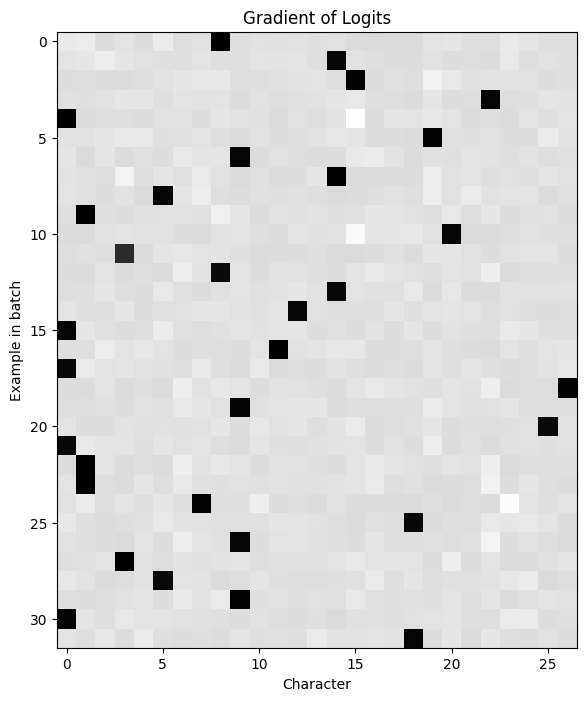

In [51]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach().cpu(), cmap='gray')
plt.title('Gradient of Logits')
plt.xlabel('Character')
plt.ylabel('Example in batch')
plt.show()

Note also that we can reduce the code in the forward pass with the built-in PyTorch cross-entropy function.

In [52]:
loss_fast = F.cross_entropy(logits, Yb)
print(f'Manually calculated loss: {loss.item():.4f}, PyTorch cross-entropy loss: {loss_fast.item():.4f}, Difference: {loss-loss_fast.abs().item()}')

Manually calculated loss: 3.3541, PyTorch cross-entropy loss: 3.3541, Difference: 0.0


## Exercise 3 - Back-Propagate through the Entire Batch Normalization Calculation

We perform batch normalization as such:

```python
bnmeani = 1.0 / batch_size * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1 / (batch_size-1) * bndiff2.sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
```

Let `hprebn` (the output of $\mathbf{C}_{cat} \mathbf{W}_1 + \mathbf{b}_1$, just before batch normalization) be $\mathbf{x}$ and `hpreact` (the output of batch normalization, just before activation) be $\mathbf{y}$. The vectors $\mathbf{x}$ and $\mathbf{y}$ are of size $m$, which is the batch size.

Formally, the batch normalization is performed by first calculating the mean of $\mathbf{x}$, which we call $\mu_B$.

$$
\mu_B = \frac{1}{m} \sum_{i=1}^m x_i
$$

Then the variance of $\mathbf{x}$ is calculated, referred to as $\sigma_B^2$.

$$
\sigma_B^2 = \frac{1}{m-1} \sum_{i=1}^m \left( x_i - \mu_B \right)^2
$$

Note that dividing by $m-1$ instead of $m$ is Bessel's correction.

We then calculate `bnraw`, which we refer to as $\hat{\mathbf{x}}$. For each $i=1,2,\dots,m$ we calculate $\hat{x}_i$ as

$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$

where $\epsilon$ is a small positive number ($1 \times 10^{-5}$ in our case).

Finally, we calculate $y_i$ for $i=1,2,\dots,m$ as

$$
y_i = \gamma \hat{x}_i + \beta
$$

where $\gamma$ and $\beta$ are the gain and bias vectors, respectively.

We want to find $\frac{\partial \mathscr{L}}{\partial x_i}$, given that we have $\frac{\partial \mathscr{L}}{\partial y_i}$. We can back-propagate our way toward $\mathbf{x}$ on step at a time, starting at $\hat{\mathbf{x}}$.

First, we want to find $\frac{\partial \mathscr{L}}{\partial \hat{x}_i}$, so we can use the chain rule to note that

$$
\frac{\partial \mathscr{L}}{\partial \hat{x}_i} = \frac{\partial \mathscr{L}}{\partial y_i} \frac{\partial y_i}{\partial \hat{x}_i}
$$

Calculating $\frac{\partial y_i}{\partial \hat{x}_i}$:

$$
\frac{\partial y_i}{\partial \hat{x}_i} = \frac{\partial}{\partial \hat{x}_i} \left( \gamma \hat{x}_i + \beta \right) = \gamma
$$

So we have

$$
\frac{\partial \mathscr{L}}{\partial \hat{x}_i} = \frac{\partial \mathscr{L}}{\partial y_i} \gamma
$$

Next, we can find $\frac{\partial \mathscr{L}}{\partial \sigma_B^2}$ using the chain rule, and remembering to sum the contributions to the gradient because $\sigma_B$ is a scalar while $\hat{\mathbf{x}}$ is a vector.

$$
\frac{\partial \mathscr{L}}{\partial \sigma_B^2} = \sum_{i=1}^m \left( \frac{\partial \mathscr{L}}{\partial \hat{x}_i} \frac{\partial \hat{x}_i}{\partial \sigma_B^2} \right)
$$

Calculating $\frac{\partial \hat{x}_i}{\partial \sigma_B^2}$:

$$
\begin{align*}
    \frac{\partial \hat{x}_i}{\partial \sigma_B^2} &= \frac{\partial}{\partial \sigma_B^2} \left( \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} \right)\\
        &= \frac{\partial}{\partial \sigma_B^2} \left( \left( x_i - \mu_B \right) \left( \sigma_B^2 + \epsilon \right)^{-\frac{1}{2}} \right)\\
        &= \left( x_i - \mu_B \right) \frac{\partial}{\partial \sigma_B^2} \left(  \left( \sigma_B^2 + \epsilon \right)^{-\frac{1}{2}} \right)\\
        &= \left( x_i - \mu_B \right) \cdot - \frac{1}{2} \left( \sigma_B^2 + \epsilon \right)^{-\frac{3}{2}} \frac{\partial}{\partial \sigma_B^2} \left( \sigma_B^2 + \epsilon \right)\\
        &= \left( x_i - \mu_B \right) \cdot - \frac{1}{2} \left( \sigma_B^2 + \epsilon \right)^{-\frac{3}{2}} \cdot 1\\
    \frac{\partial \hat{x}_i}{\partial \sigma_B^2} &= - \frac{\left( x_i - \mu_B \right)}{2 \left( \sigma_B^2 + \epsilon \right)^{\frac{3}{2}}}
\end{align*}
$$

So we can express $\frac{\partial \mathscr{L}}{\partial \sigma_B^2}$ as

$$
\begin{align*}
    \frac{\partial \mathscr{L}}{\partial \sigma_B^2} &= \sum_{i=1}^m \left( \frac{\partial \mathscr{L}}{\partial \hat{x}_i} \frac{\partial \hat{x}_i}{\partial \sigma_B^2} \right)\\
        &= \sum_{i=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_i} \gamma \cdot - \frac{\left( x_i - \mu_B \right)}{2 \left( \sigma_B^2 + \epsilon \right)^{\frac{3}{2}}} \right)\\
    \frac{\partial \mathscr{L}}{\partial \sigma_B^2} &= -\frac{1}{2} \gamma \sum_{i=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_i} \frac{\left( x_i - \mu_B \right)}{\left( \sigma_B^2 + \epsilon \right)^{\frac{3}{2}}} \right)
\end{align*}
$$

We follow a similar process for $\frac{\partial \mathscr{L}}{\partial \mu_B^2}$. The scalar $\mu_B$ is used $m$ times by $\hat{\mathbf{x}}$ (once for each $\hat{x}_i$) and once by $\sigma_B^2$. All of these contributions sum up to get the full expression for the gradient of $\mu_B$.

$$
\frac{\partial \mathscr{L}}{\partial \mu_B} = \sum_{i=1}^m \left( \frac{\partial \mathscr{L}}{\partial \hat{x}_i} \frac{\partial \hat{x}_i}{\partial \mu_B} \right) + \frac{\partial \mathscr{L}}{\partial \sigma_B^2} \frac{\partial \sigma_B^2}{\partial \mu_B}
$$

Calculating $\frac{\partial \hat{x}_i}{\partial \mu_B}$:

$$
\begin{align*}
    \frac{\partial \hat{x}_i}{\partial \mu_B} &= \frac{\partial}{\partial \mu_B} \left( \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} \right) = - \frac{1}{\sqrt{\sigma_B^2 + \epsilon}}
\end{align*}
$$

Calculating $\frac{\partial \sigma_B^2}{\partial \mu_B}$:

$$
\begin{align*}
    \frac{\partial \sigma_B^2}{\partial \mu_B} &= \frac{\partial}{\partial \mu_B} \left( \frac{1}{m-1} \sum_{i=1}^m \left( x_i - \mu_B \right)^2 \right)\\
        &= \frac{\partial}{\partial \mu_B} \left( \frac{1}{m-1} \left( \left( x_1 - \mu_B \right)^2 + \left( x_2 - \mu_B \right)^2 + \dots + \left( x_m - \mu_B \right)^2 \right) \right)\\
        &= \frac{1}{m-1} \left( \frac{\partial}{\partial \mu_B} \left( \left( x_1 - \mu_B \right)^2 + \left( x_2 - \mu_B \right)^2 + \dots + \left( x_m - \mu_B \right)^2 \right) \right)\\
        &= \frac{1}{m-1} \left( \frac{\partial}{\partial \mu_B} \left( x_1 - \mu_B \right)^2 + \frac{\partial}{\partial \mu_B} \left( x_2 - \mu_B \right)^2 + \dots + \frac{\partial}{\partial \mu_B} \left( x_m - \mu_B \right)^2 \right)\\
        &= \frac{1}{m-1} \left( 2 \left( x_1 - \mu_B \right) \frac{\partial}{\partial \mu_B} \left( x_1 - \mu_B \right) + 2 \left( x_2 - \mu_B \right) \frac{\partial}{\partial \mu_B} \left( x_2 - \mu_B \right) + \dots + 2 \left( x_m - \mu_B \right) \frac{\partial}{\partial \mu_B} \left( x_m - \mu_B \right) \right)\\
        &= \frac{1}{m-1} \left( 2 \left( x_1 - \mu_B \right) + 2 \left( x_2 - \mu_B \right) + \dots + 2 \left( x_m - \mu_B \right) \right)\\
        &= \frac{2}{m-1} \left( \left( x_1 - \mu_B \right) + \left( x_2 - \mu_B \right) + \dots + \left( x_m - \mu_B \right) \right)\\
        &= \frac{2}{m-1} \left( x_1 + x_2 + \dots + x_m - \mu_B - \mu_B - \dots - \mu_B \right)\\
    \frac{\partial \sigma_B^2}{\partial \mu_B} &= \frac{2}{m-1} \left( \sum_{i=1}^m x_i - m \mu_B \right)
\end{align*}
$$

Note that since $\mu_B = \frac{1}{m} \sum_{i=1}^m x_i$, we also have $m \mu_B = \sum_{i=1}^m x_i$.

$$
\begin{align*}
    \frac{\partial \sigma_B^2}{\partial \mu_B} &= \frac{2}{m-1} \left( m \mu_B - m \mu_B \right)\\
    \frac{\partial \sigma_B^2}{\partial \mu_B} &= 0
\end{align*}
$$

Putting the components for the gradient of $\mu_B$ together:

$$
\begin{align*}
\frac{\partial \mathscr{L}}{\partial \mu_B} &= \sum_{i=1}^m \left( \frac{\partial \mathscr{L}}{\partial \hat{x}_i} \frac{\partial \hat{x}_i}{\partial \mu_B} \right) + \frac{\partial \mathscr{L}}{\partial \sigma_B^2} \frac{\partial \sigma_B^2}{\partial \mu_B}\\
    &= \sum_{i=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_i} \gamma \left( - \frac{1}{\sqrt{\sigma_B^2 + \epsilon}} \right) \right) + 0\\
 \frac{\partial \mathscr{L}}{\partial \mu_B} &= - \gamma \frac{1}{\sqrt{\sigma_B^2 + \epsilon}} \sum_{i=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_i} \right)
\end{align*}
$$

Finally, we can calculate $\frac{\partial \mathscr{L}}{\partial x_i}$. Note that the scalars $\mu_B$ and $\sigma_B^2$ depend on each $x_i$. And, since $\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$, each $\hat{x}_i$ depends on $x_i$. So for each $x_i$, for $i=1,2,\dots,m$, there are three contributions to the gradient.

$$
\frac{\partial \mathscr{L}}{\partial x_i} = \frac{\partial \mathscr{L}}{\partial \hat{x}_i} \frac{\partial \hat{x}_i}{\partial x_i} + \frac{\partial \mathscr{L}}{\partial \mu_B} \frac{\partial \mu_B}{\partial x_i} + \frac{\partial \mathscr{L}}{\partial \sigma_B^2} \frac{\partial \sigma_B^2}{\partial x_i}
$$

Calculating $\frac{\partial \hat{x}_i}{\partial x_i}$:

$$
\frac{\partial \hat{x}_i}{\partial x_i} = \frac{\partial}{\partial x_i} \left( \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} \right) = \frac{1}{\sqrt{\sigma_B^2 + \epsilon}}
$$

Calculating $\frac{\partial \mu_B}{\partial x_i}$:

$$
\begin{align*}
    \frac{\partial \mu_B}{\partial x_i} &= \frac{\partial}{\partial x_i} \left( \frac{1}{m} \sum_{i=1}^m x_i \right)\\
        &= \frac{1}{m} \frac{\partial}{\partial x_i} \left( x_1 + x_2 + \dots + x_i + \dots + x_m \right)\\
        &= \frac{1}{m} \cdot \left( 0 + 0 + \dots + 1 + \dots + 0 \right)\\
        &= \frac{1}{m} \cdot 1\\
    \frac{\partial \mu_B}{\partial x_i} &= \frac{1}{m}
\end{align*}
$$

Calculating $\frac{\partial \sigma_B^2}{\partial x_i}$:

$$
\begin{align*}
    \frac{\partial \sigma_B^2}{\partial x_i} &= \frac{\partial}{\partial x_i} \left( \frac{1}{m-1} \sum_{i=1}^m \left( x_i - \mu_B \right)^2 \right)\\
        &= \frac{1}{m-1} \frac{\partial}{\partial x_i} \left( \sum_{i=1}^m \left( x_i - \mu_B \right)^2 \right)\\
        &= \frac{1}{m-1} \frac{\partial}{\partial x_i} \left( \left( x_1 - \mu_B \right)^2 + \left( x_2 - \mu_B \right)^2 + \dots + \left( x_i - \mu_B \right)^2 + \dots + \left( x_m - \mu_B \right)^2 \right)\\
        &= \frac{1}{m-1} \left( 0 + 0 + \dots + \frac{\partial}{\partial x_i} \left( x_i - \mu_B \right)^2 + \dots + 0 \right)\\
        &= \frac{1}{m-1} \left( \frac{\partial}{\partial x_i} \left( x_i - \mu_B \right)^2 \right)\\
        &= \frac{1}{m-1} \left( 2 \left( x_i - \mu_B \right) \right)\\
    \frac{\partial \sigma_B^2}{\partial x_i} &= \frac{2 \left( x_i - \mu_B \right)}{m-1}
\end{align*}
$$

Therefore, $\frac{\partial \mathscr{L}}{\partial x_i}$ can be expressed as

$$
\begin{align*}
    \frac{\partial \mathscr{L}}{\partial x_i} &= \frac{\partial \mathscr{L}}{\partial \hat{x}_i} \frac{\partial \hat{x}_i}{\partial x_i} + \frac{\partial \mathscr{L}}{\partial \mu_B} \frac{\partial \mu_B}{\partial x_i} + \frac{\partial \mathscr{L}}{\partial \sigma_B^2} \frac{\partial \sigma_B^2}{\partial x_i}\\
        &= \frac{\partial \mathscr{L}}{\partial y_i} \gamma \frac{1}{\sqrt{\sigma_B^2 + \epsilon}} + \left( - \gamma \frac{1}{\sqrt{\sigma_B^2 + \epsilon}} \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \right) \right) \frac{1}{m} + \left( -\frac{1}{2} \gamma \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \frac{\left( x_j - \mu_B \right)}{\left( \sigma_B^2 + \epsilon \right)^{\frac{3}{2}}} \right) \right) \frac{2 \left( x_i - \mu_B \right)}{m-1}\\
        &= \frac{\partial \mathscr{L}}{\partial y_i} \gamma \frac{1}{\sqrt{\sigma_B^2 + \epsilon}} - \gamma \frac{1}{\sqrt{\sigma_B^2 + \epsilon}} \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \right) \frac{1}{m} - \frac{1}{2} \gamma \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \frac{\left( x_j - \mu_B \right)}{\left( \sigma_B^2 + \epsilon \right)^{\frac{3}{2}}} \right) \frac{2 \left( x_i - \mu_B \right)}{m-1}\\
        &= \gamma \frac{1}{\sqrt{\sigma_B^2 + \epsilon}} \left( \frac{\partial \mathscr{L}}{\partial y_i} - \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \right) \frac{1}{m} - \frac{1}{2} \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \frac{\left( x_j - \mu_B \right)}{\sigma_B^2 + \epsilon} \right) \frac{2 \left( x_i - \mu_B \right)}{m-1} \right)\\
        &= \gamma \frac{1}{\sqrt{\sigma_B^2 + \epsilon}} \left( \frac{\partial \mathscr{L}}{\partial y_i} - \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \right) \frac{1}{m} - \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \frac{\left( x_j - \mu_B \right)}{\sigma_B^2 + \epsilon} \right) \frac{\left( x_i - \mu_B \right)}{m-1} \right)\\
        &= \gamma \frac{1}{\sqrt{\sigma_B^2 + \epsilon}} \left( \frac{\partial \mathscr{L}}{\partial y_i} - \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \right) \frac{1}{m} - \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \frac{\left( x_j - \mu_B \right)}{\sqrt{\sigma_B^2 + \epsilon}\sqrt{\sigma_B^2 + \epsilon}} \right) \frac{\left( x_i - \mu_B \right)}{m-1} \right)\\
        &= \gamma \frac{1}{\sqrt{\sigma_B^2 + \epsilon}} \left( \frac{\partial \mathscr{L}}{\partial y_i} - \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \right) \frac{1}{m} - \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \frac{\left( x_j - \mu_B \right)}{\sqrt{\sigma_B^2 + \epsilon}} \right) \frac{\left( x_i - \mu_B \right)}{(m-1)\sqrt{\sigma_B^2 + \epsilon}} \right)\\
    \frac{\partial \mathscr{L}}{\partial x_i} &= \gamma \frac{1}{\sqrt{\sigma_B^2 + \epsilon}} \left( \frac{\partial \mathscr{L}}{\partial y_i} - \frac{1}{m} \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \right) - \frac{1}{m-1} \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \frac{\left( x_j - \mu_B \right)}{\sqrt{\sigma_B^2 + \epsilon}} \right) \frac{\left( x_i - \mu_B \right)}{\sqrt{\sigma_B^2 + \epsilon}} \right)
\end{align*}
$$

Since $\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$, we have

$$
\begin{align*}
    \frac{\partial \mathscr{L}}{\partial x_i} &= \gamma \frac{1}{\sqrt{\sigma_B^2 + \epsilon}} \left( \frac{\partial \mathscr{L}}{\partial y_i} - \frac{1}{m} \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \right) - \frac{1}{m-1} \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \hat{x_j} \right) \hat{x_i} \right)\\
        &= \gamma \frac{1}{\sqrt{\sigma_B^2 + \epsilon}} \left( \frac{\partial \mathscr{L}}{\partial y_i} - \frac{1}{m} \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \right) - \frac{m}{(m-1)m} \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \hat{x_j} \right) \hat{x_i} \right)\\
    \frac{\partial \mathscr{L}}{\partial x_i} &= \gamma \frac{1}{m \sqrt{\sigma_B^2 + \epsilon}} \left( m \frac{\partial \mathscr{L}}{\partial y_i} - \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \right) - \frac{m}{m-1} \sum_{j=1}^m \left( \frac{\partial \mathscr{L}}{\partial y_j} \hat{x_j} \right) \hat{x_i} \right)
\end{align*}
$$

In [53]:
dhprebn = bngain * (1.0 / batch_size) * bnvar_inv * ( batch_size * dhpreact - dhpreact.sum(0) - (batch_size / (batch_size - 1)) * (dhpreact * bnraw).sum(0) * bnraw )
cmp('dhprebn', dhprebn, hprebn)

dhprebn         | exact: False | approximate: True  | maxdiff: 1.3969838619232178e-09


Note that we can also reduce the batch normalization code down to one line.

In [54]:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print(f'Maximum difference between hpreact and hpreact_fast: {(hpreact - hpreact_fast).abs().max().item()}')

Maximum difference between hpreact and hpreact_fast: 4.76837158203125e-07


## Exercise 4 - Training the Neural Network with Manual Back-Propagation

In [55]:
n_embd = 10
n_hidden = 64

C = torch.randn((vocab_size, n_embd),             generator=g, device=device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g, device=device) * (5.0/3.0) / (math.sqrt(n_embd * block_size))
b1 = torch.randn(n_hidden,                        generator=g, device=device) * 0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g, device=device) * 0.1
b2 = torch.randn(vocab_size,                      generator=g, device=device) * 0.1

bngain = torch.randn((1, n_hidden), device=device) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden), device=device) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

print(f'Number of parameters: {sum(p.nelement() for p in parameters)}')

Number of parameters: 4137


In [56]:
batch_size = 32
max_steps = 200_000
lossi = []

# No need to have PyTorch keep track of gradients since we will do so manually
with torch.no_grad():
    for i in range(max_steps):

        # --- Batch ---
        ix = torch.randint(0, X_tr.shape[0], (batch_size,), generator=g, device=device)
        Xb, Yb = X_tr[ix], Y_tr[ix]

        # --- Forward pass ---
        # Embedding vector from lookup table C
        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1)
        # First layer
        hprebn = embcat @ W1 + b1
        # Batch normalization
        bnmeani = 1.0 / batch_size * hprebn.sum(0, keepdim=True)
        bndiff = hprebn - bnmeani
        bndiff2 = bndiff**2
        bnvar = 1 / (batch_size-1) * bndiff2.sum(0, keepdim=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = bndiff * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # Non-linearity
        h = torch.tanh(hpreact)
        # Second layer
        logits = h @ W2 + b2
        # Loss calculation
        loss = F.cross_entropy(logits, Yb)

        # --- Backward pass ---
        # Initialize zero gradients
        for p in parameters:
            p.grad = None
        # Softmax layer back-propagation
        dlogits = F.softmax(logits, 1)
        dlogits[range(batch_size), Yb] -= 1
        dlogits /= batch_size
        # Second layer back-propagation
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # Non-linearity back-propagation
        dhpreact = dh * (1.0 - h.pow(2))
        # Batch normalization back-propagation
        dbngain = (dhpreact * bnraw).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain * (1.0 / batch_size) * bnvar_inv * ( batch_size * dhpreact - dhpreact.sum(0) - (batch_size / (batch_size - 1)) * (dhpreact * bnraw).sum(0) * bnraw )
        # First layer back-propagation
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # Embedding layer back-propagation
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k, j]
                dC[ix] += demb[k, j]

        # --- Parameter updates ---
        gradients: List[Tensor] = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

        lr = 0.1 if i < max_steps / 2 else 0.01
        for p, grad in zip(parameters, gradients):
            p.data += -lr * grad

        if max_steps < 25 or (i % (max_steps // 25)) == 0:
            print(f'Iteration {i}/{max_steps}, loss: {loss.item()}')
        lossi.append(loss)

Iteration 0/200000, loss: 3.2880027294158936
Iteration 8000/200000, loss: 2.5092251300811768
Iteration 16000/200000, loss: 2.515756130218506
Iteration 24000/200000, loss: 2.2205543518066406
Iteration 32000/200000, loss: 1.9139076471328735
Iteration 40000/200000, loss: 2.3487486839294434
Iteration 48000/200000, loss: 2.431751012802124
Iteration 56000/200000, loss: 2.493825674057007
Iteration 64000/200000, loss: 2.1253273487091064
Iteration 72000/200000, loss: 2.160828113555908
Iteration 80000/200000, loss: 2.0222008228302
Iteration 88000/200000, loss: 2.1858842372894287
Iteration 96000/200000, loss: 2.4489762783050537
Iteration 104000/200000, loss: 2.434293746948242
Iteration 112000/200000, loss: 2.080416679382324
Iteration 120000/200000, loss: 1.9263767004013062
Iteration 128000/200000, loss: 1.8950459957122803
Iteration 136000/200000, loss: 2.336491823196411
Iteration 144000/200000, loss: 2.154329538345337
Iteration 152000/200000, loss: 2.1447949409484863
Iteration 160000/200000, loss

In [57]:
# Calibrate batch normalization parameters (bnmean and bnvar) after training
with torch.no_grad():
    emb = C[X_tr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [58]:
@torch.no_grad()
def loss_of_split(split: Literal['train'] | Literal['test'] | Literal['val']):
    x, y = {
        'train': (X_tr, Y_tr),
        'val': (X_dev, Y_dev),
        'test': (X_te, Y_te)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h_pre_act = embcat @ W1 + b1
    h_pre_act = bngain * (h_pre_act - bnmean) / (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    print(f'Loss of \'{split}\' split: {loss.item():.4f}')

In [59]:
loss_of_split('train')
loss_of_split('val')

Loss of 'train' split: 2.4527
Loss of 'val' split: 2.4797


In [60]:
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED + 1)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context], device=device)]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(str().join(itos[i] for i in out))

kan.
minor.
slea.
emmena.
ridgianaleighani.
liana.
kenslam.
jara.
caylonna.
karyan.
ediet.
juu.
elouelahiyah.
kalynn.
torevonjonis.
ismeya.
juon.
issietteric.
dylintzion.
rura.
